### Debug environment for the MARL process

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *
from utils.params import *
from utils.retrieve_sim import *

from importlib import reload
import utils

input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

import os
try:
    os.mkdir('screencaps')
except:
    pass


In [103]:
# Load the model and make the right environment
reload(utils.agents)
from utils.agents import *
num_episode=500#250#500
test_interval=10#0
num_test=10#50
num_iteration=200
BATCH_SIZE=128#64#128
save_sim_intv=50
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND
N = 2
env = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
                 uses_boundary=False
#                  uses_boundary=True
        ).unwrapped
agent = AC2Agent(device, env.N, env.nf, env.na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)
agent.load_model('models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_749')
steps = 0

Loading model from models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_749


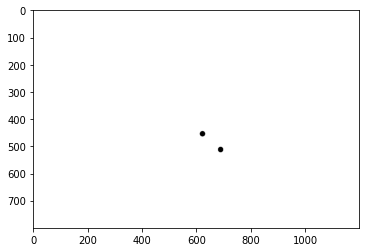

In [104]:
# Copy the code from train and test functions, and prepare to run it
agent.set_train(False)
cum_reward = 0
reward_hist = []

state = env.reset()
if agent.centralized:
    state = env.state
state = torch.from_numpy(state).float()
state = Variable(state)

img = env.render(mode="rgb_array")
env.close()
plt.imshow(img)

Current env state: (loc in x, loc in y, vel in x, vel in y) 
 [[ 0.          0.17738344]
 [ 0.         -0.15457512]
 [ 0.99999988  0.99999988]
 [-0.99999982 -0.99999988]] 
 Observed state: (4x relative states, 2x self and neighbor actions, 1x time count)
 [[[ 0.00000000e+00 -1.77383442e-01]
  [ 0.00000000e+00  1.54575116e-01]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  5.96046448e-08]
  [ 9.99999881e-01  9.99999881e-01]
  [-9.99999821e-01 -9.99999881e-01]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.77383442e-01  0.00000000e+00]
  [-1.54575116e-01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [-5.96046448e-08  0.00000000e+00]
  [ 9.99999881e-01  9.99999881e-01]
  [-9.99999821e-01 -9.99999881e-01]
  [ 0.00000000e+00  0.00000000e+00]]] 
Reward: 
 [-94.1134224 -94.1134224]


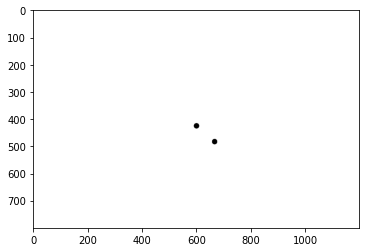

In [105]:
# Copy the code from train and test functions, and run it iteration by iteration
with torch.no_grad():  
    # Try to pick an action, react, and store the resulting behavior in the pool here
    if agent.centralized:
        action = agent.select_action(state, **{
                'steps_done':steps, 'rand':False, 'num_sample':50, 'action_space':action_space
            }).T
    else:
        actions = []
        for i in range(N):
            action = agent.select_action(state[i], **{
                'steps_done':steps, 'rand':False, 'num_sample':50, 'action_space':action_space
            })
            actions.append(action)
        action = np.array(actions).T 

    next_state, reward, done, _ = env.step(action)
    img = env.render(mode="rgb_array")
    env.close()
    plt.imshow(img)
    
    if agent.centralized:
        next_state = env.state
    print("Current env state: (loc in x, loc in y, vel in x, vel in y) \n", env.state[:4], 
          "\n Observed state: (4x relative states, 2x self and neighbor actions, 1x time count)\n", next_state, 
          "\nReward: \n", reward)
    
    next_state = Variable(torch.from_numpy(next_state).float()) # The float() probably avoids bug in net.forward()
    state = next_state
    cum_reward += sum(reward)
    reward_hist.append(reward)
    steps += 1

    if done:
        print("Took ", steps, " steps to converge")
        

In [106]:
env.Adj

array([[0., 1.],
       [1., 0.]])

In [111]:
diff = env.state.T.reshape((env.N,env.ns,1)) - env.state.reshape((1,env.ns,env.N))

diff_norm = np.linalg.norm(diff[:,:2,:], ord=2, axis=1)

diff_norm

array([[0.        , 0.23528356],
       [0.23528356, 0.        ]])

In [108]:
action

array([[ 0.9999999,  0.9999999],
       [-0.9999998, -0.9999999]], dtype=float32)

In [107]:
env.state

array([[ 0.        ,  0.17738344],
       [ 0.        , -0.15457512],
       [ 0.99999988,  0.99999988],
       [-0.99999982, -0.99999988],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [110]:
act_params = agent.netA(Variable(next_state[1].view(1, -1, N)))
act_params

tensor([[ 1., -1.,  1.,  1.]], grad_fn=<CatBackward>)

In [95]:
pred_action = torch.zeros(1,agent.na)
pred_probs = torch.zeros(1)

distrb = torch.distributions.Normal(
    act_params[:,:agent.na],
    torch.diag( nn.functional.softplus( act_params[:,agent.na:] ) )
)
aa = distrb.sample()
aa

tensor([[ 0.7810, -1.2545]])

In [96]:
pred_action = torch.clamp( aa, agent.action_range[0], agent.action_range[1] )
pred_probs = distrb.log_prob(pred_action)
pred_action, pred_probs

(tensor([[ 0.7810, -1.0000]]),
 tensor([[-1.2054, -1.1915]], grad_fn=<SubBackward0>))

In [90]:
nn.functional.softplus( act_params[:,agent.na:] )

tensor([[1.3133, 1.3133]], grad_fn=<SoftplusBackward>)

In [91]:
aa = distrb.sample()
aa

tensor([[-0.4820, -2.4129]])

In [92]:
torch.clamp( aa, agent.action_range[0], agent.action_range[1] )

tensor([[-0.4820, -1.0000]])

In [102]:
agent.rand_modeA

2